In [ ]:
### DATOS ###
#age (11-98) NUM
#sex (1:Hombre, 0:Mujer) CAT
#cp - Dolor de pecho (0:Asintomatico, 1:Angina tipica, 2:Angina atipica, 3:Dolor no anginal) CAT
#trestbps - Presion en sangre (94-200) NUM
#chol - Colesterol (126-564) NUM
#fbs - Si el azucar es mayor a 120 mg/dl (1:Si, 0:No) CAT
#restecg - Resultados de electrocardiograma (0-2) CAT
#thalach - Frecuencia cardiaca maxima (71-202) NUM
#exang - Angina inducida por ejercicio (1:Si,0:No) CAT
#oldpeak - depresion ST inducida por ejercicio en relacion al reposo (0-6.2) NUM
#slope - Pendiente del segmento ST de ejercicio máximo: (0: pendiente ascendente 1: plano 2: pendiente descendente) CAT
#ca - Numero de vasos mayores coloreados en fluoroscopia NUM
#thal - Resultados de prueba thal (0: Normal; 1: Fixed defect; 2: Reversable defect) CAT
#target - Si tiene hipertension o no (1:Si 0:No) CAT


In [113]:
import kagglehub
import pandas as pd
import os

#Fuente
data = kagglehub.dataset_download("prosperchuks/health-dataset")
file_path = os.path.join(data, "hypertension_data.csv")

#Convertir a DataFrame
df = pd.read_csv(file_path)
print(df.head())

    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0  57.0  1.0   3       145   233    1        0      150      0      2.3   
1  64.0  0.0   2       130   250    0        1      187      0      3.5   
2  52.0  1.0   1       130   204    0        0      172      0      1.4   
3  56.0  0.0   1       120   236    0        1      178      0      0.8   
4  66.0  0.0   0       120   354    0        1      163      1      0.6   

   slope  ca  thal  target  
0      0   0     1       1  
1      0   0     2       1  
2      2   0     2       1  
3      2   0     2       1  
4      2   0     2       1  


In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#Revisar si hay datos null
print(df.isnull().sum())
df = df.dropna()

#Revisar si hay datos duplicados
print("\nCantidad de datos duplicados: ", df.duplicated().sum())

#Eliminar columnas con datos complejos (No necesarias en el planteamiento del proyecto)
df = df.drop(columns=['restecg','oldpeak','slope','ca','thal'])

#Ver datos
print(df.describe())
print(df.head())

age          0
sex         25
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64

Cantidad de datos duplicados:  0
                age          sex            cp      trestbps          chol  \
count  26058.000000  26058.00000  26058.000000  26058.000000  26058.000000   
mean      55.655730      0.50000      0.956635    131.590682    246.286591   
std       15.190407      0.50001      1.022467     17.597086     51.651701   
min       11.000000      0.00000      0.000000     94.000000    126.000000   
25%       44.000000      0.00000      0.000000    120.000000    211.000000   
50%       56.000000      0.50000      1.000000    130.000000    240.000000   
75%       67.000000      1.00000      2.000000    140.000000    275.000000   
max       98.000000      1.00000      3.000000    200.000000    564.000000   

                fbs       thalach       

age         0
trestbps    0
chol        0
sex         0
cp          0
fbs         0
thalach     0
exang       0
target      0
dtype: int64


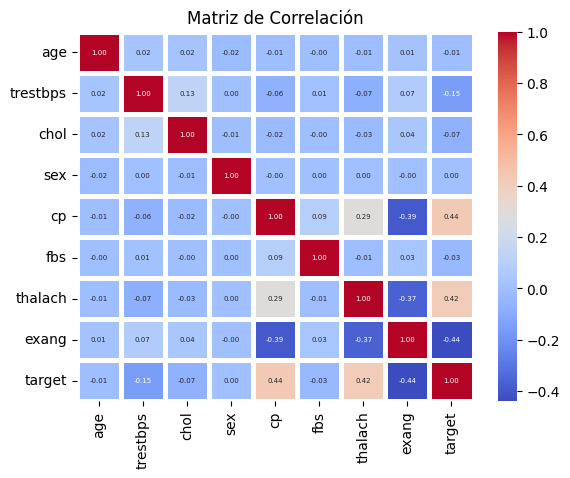

In [115]:
#Escalar datos numericos
scaler = MinMaxScaler()
colnums = ['age','trestbps','chol']
df_escalado = pd.DataFrame(scaler.fit_transform(df[colnums]), columns=colnums)

#Combinar de nuevo en un solo DataFrame
df_restantes = df.drop(columns=colnums)
df = pd.concat([df_escalado, df_restantes], axis=1)

#Eliminar nulos despues de escalar
df = df.dropna()
print(df.isnull().sum())

#Matriz de correlacion
matriz_correlacion = df.corr()
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 5}, linewidths=2.5)
plt.title('Matriz de Correlación')
plt.show()


In [116]:
#Modelo de IA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Separar los datos en X y Y
X = df.drop(columns='target')
y = df['target']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, )

# Crear el modelo XGBClassifier
xgb = XGBClassifier(n_estimators=150, max_depth=7, learning_rate=0.2, random_state=42, colsample_bytree=1.0, subsample=1.0)

# Entrenar el modelo
xgb.fit(X_train, y_train)

# Hacer predicciones
y_pred = xgb.predict(X_test)

# Evaluar el modelo
print("Precisión del modelo:", accuracy_score(y_test, y_pred))


Precisión del modelo: 0.9636363636363636


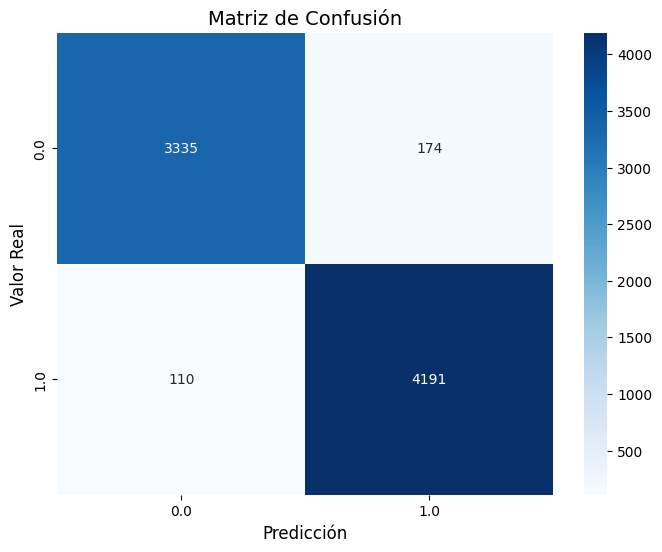

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3509
         1.0       0.96      0.97      0.97      4301

    accuracy                           0.96      7810
   macro avg       0.96      0.96      0.96      7810
weighted avg       0.96      0.96      0.96      7810



In [117]:
#Ver Metricas
from sklearn.metrics import classification_report, confusion_matrix

y_pred = xgb.predict(X_test)

#Matriz de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0.0, 1.0], yticklabels=[0.0, 1.0])
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Valor Real", fontsize=12)
plt.title("Matriz de Confusión", fontsize=14)
plt.show()

#Reporte de clasificacion
print(classification_report(y_test, y_pred))


In [118]:
#GridSearch utilizado para encontrar mejores parametros
from sklearn.model_selection import GridSearchCV

# Configurar los hiperparámetros a buscar
parametros = {
    'n_estimators': [50, 100, 150],  # Número de árboles
    'max_depth': [3, 5, 7],  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0],  # Porción de muestras utilizadas por árbol
    'colsample_bytree': [0.6, 0.8, 1.0]  # Porción de características usadas por árbol
}

# Configurar la búsqueda de parámetros con validación cruzada
grid_search = GridSearchCV(estimator=xgb, param_grid=parametros, cv=5, scoring='accuracy', verbose=1)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Resultados de los mejores parámetros y precisión
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de precisión:", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Mejor puntuación de precisión: 0.9580203397282716


In [119]:
#Guardar modelo entrenado y escalado
import pickle

# Guardar xgb
with open("modelo_XGBClassifier.pkl", "wb") as archivo:
    pickle.dump(xgb, archivo)

#Guardar escalado
with open("modelo_escalado.pkl", "wb") as archivo:
    pickle.dump(scaler, archivo)